In this notebook, you will implement the forward longitudinal vehicle model. The model accepts throttle inputs and steps through the longitudinal dynamic equations. Once implemented, you will be given a set of inputs that drives over a small road slope to test your model.

The input to the model is a throttle percentage $x_\theta \in [0,1]$ which provides torque to the engine and subsequently accelerates the vehicle for forward motion. 

The dynamic equations consist of many stages to convert throttle inputs to wheel speed (engine -> torque converter -> transmission -> wheel). These stages are bundled together in a single inertia term $J_e$ which is used in the following combined engine dynamic equations.

\begin{align}
    J_e \dot{\omega}_e &= T_e - (GR)(r_{eff} F_{load}) \\ m\ddot{x} &= F_x - F_{load}
\end{align}

Where $T_e$ is the engine torque, $GR$ is the gear ratio, $r_{eff}$ is the effective radius, $m$ is the vehicle mass, $x$ is the vehicle position, $F_x$ is the tire force, and $F_{load}$ is the total load force. 

The engine torque is computed from the throttle input and the engine angular velocity $\omega_e$ using a simplified quadratic model. 

\begin{align}
    T_e = x_{\theta}(a_0 + a_1 \omega_e + a_2 \omega_e^2)
\end{align}

The load forces consist of aerodynamic drag $F_{aero}$, rolling friction $R_x$, and gravitational force $F_g$ from an incline at angle $\alpha$. The aerodynamic drag is a quadratic model and the friction is a linear model.

\begin{align}
    F_{load} &= F_{aero} + R_x + F_g \\
    F_{aero} &= \frac{1}{2} C_a \rho A \dot{x}^2 = c_a \dot{x}^2\\
    R_x &= N(\hat{c}_{r,0} + \hat{c}_{r,1}|\dot{x}| + \hat{c}_{r,2}\dot{x}^2) \approx c_{r,1} \dot{x}\\
    F_g &= mg\sin{\alpha}
\end{align}

Note that the absolute value is ignored for friction since the model is used for only forward motion ($\dot{x} \ge 0$). 
 
The tire force is computed using the engine speed and wheel slip equations.

\begin{align}
    \omega_w &= (GR)\omega_e \\
    s &= \frac{\omega_w r_e - \dot{x}}{\dot{x}}\\
    F_x &= \left\{\begin{array}{lr}
        cs, &  |s| < 1\\
        F_{max}, & \text{otherwise}
        \end{array}\right\} 
\end{align}

Where $\omega_w$ is the wheel angular velocity and $s$ is the slip ratio. 

We setup the longitudinal model inside a Python class below. The vehicle begins with an initial velocity of 5 m/s and engine speed of 100 rad/s. All the relevant parameters are defined and like the bicycle model, a sampling time of 10ms is used for numerical integration.

In [3]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

class Vehicle():
    def __init__(self):
        # ==================================
        #  Parâmetros
        # ==================================
    
        # Acelerador para torque do motor
        self.a_0 = 400
        self.a_1 = 0.1
        self.a_2 = -0.0002
        
        # Relação de marcha, raio efetivo, massa + inércia
        self.GR = 0.35
        self.r_e = 0.3
        self.J_e = 10
        self.m = 2000
        self.g = 9.81
        
        # Coeficientes aerodinâmicos e de atrito
        self.c_a = 1.36
        self.c_r1 = 0.01
        
        # Força do pneu 
        self.c = 10000
        self.F_max = 10000
        
        # Variáveis de estado
        self.x = 0
        self.v = 5
        self.a = 0
        self.w_e = 100
        self.w_e_dot = 0
        
        self.sample_time = 0.01
        
    def reset(self):
        # reinicializar variáveis de estado
        self.x = 0
        self.v = 5
        self.a = 0
        self.w_e = 100
        self.w_e_dot = 0

Implement the combined engine dynamic equations along with the force equations in the cell below. The function $\textit{step}$ takes the throttle $x_\theta$ and incline angle $\alpha$ as inputs and performs numerical integration over one timestep to update the state variables. Hint: Integrate to find the current position, velocity, and engine speed first, then propagate those values into the set of equations.

In [4]:
class Vehicle(Vehicle): #heranca Vehicle trecho codigo anterior
    def step(self, throttle, alpha):
        # ==================================
        #  Modelo do veículo
        # ==================================

        # Equação do torque do motor T_e
        T_e = throttle * (self.a_0 + self.a_1*self.w_e + self.a_2*self.w_e**2)

        # Equação da força aerodinâmica F_areo
        F_areo = self.c_a * self.v**2

        # Equação da força de atrito de rolamento R_x
        R_x = self.c_r1 * self.v

        # Equação da força gravitacional F_g
        F_g = self.m * self.g * np.sin(alpha)

        # Equação da carga total F_load
        F_load = F_areo + R_x + F_g

        # Equação da aceleração angular (dinâmica do motor) w_e_dot  
        self.w_e_dot = (T_e - self.GR*self.r_e*F_load) / self.J_e
        
        # Cálculos intermediários para a equação da força do pneu
        w_w = self.GR * self.w_e # w_w velocidade ang. roda
        s = (w_w*self.r_e - self.v) / self.v # s razão deslizamento

        # Equação da força do pneu F_x
        if abs(s) < 1:
            F_x = self.c * s
        else:
            F_x = self.F_max

        # Equação da aceleração resolvida por x_ddot (dinâmica do motor)
        self.a = (F_x - F_load) / self.m # m\ddot{x} = F_x - F_{load}

        # Atualizações dos estados do veículo; integração numérica
        self.w_e += self.w_e_dot * self.sample_time #velocidae angular
        self.v += self.a * self.sample_time #velocidade veiculo = a*t
        #posicao do veiculo x = v*t - (1/2)*a*t^2
        self.x += (self.v * self.sample_time) - (0.5 * self.a * self.sample_time**2) 


Using the model, you can send constant throttle inputs to the vehicle in the cell below. You will observe that the velocity converges to a fixed value based on the throttle input due to the aerodynamic drag and tire force limit. A similar velocity profile can be seen by setting a negative incline angle $\alpha$. In this case, gravity accelerates the vehicle to a terminal velocity where it is balanced by the drag force.

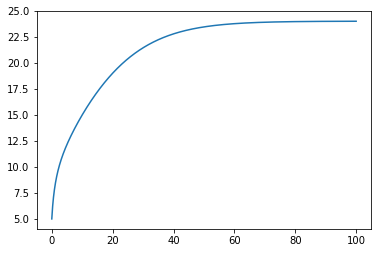

In [5]:
# Tempo de amostragem para integração numérica
sample_time = 0.01 # 0.01 segundos; intervalo de tempo entre cada amostra

# Tempo total da simulação
time_end = 100

# Instância da classe Vehicle, representando o modelo do veículo
model = Vehicle()

# Array de valores de tempo usando o intervalo de amostragem
# 0 = ponto de início, time_end = ponto final, step = espaçamento entre
t_data = np.arange(0, time_end, sample_time)

# Array de zeros para armazenar os valores de velocidade durante a simulação
v_data = np.zeros_like(t_data)

# Porcentagem de aceleração entre 0 e 1
throttle = 0.2

# Ângulo de inclinação (em radianos)
alpha = 0

# Loop para simulação ao longo do tempo
for i in range(t_data.shape[0]):
    # Armazena a velocidade atual no array v_data
    v_data[i] = model.v
    # Atualiza o modelo do veículo para o próximo passo de tempo
    model.step(throttle, alpha)

# Plota o gráfico da velocidade em função do tempo
plt.plot(t_data, v_data)
plt.show()


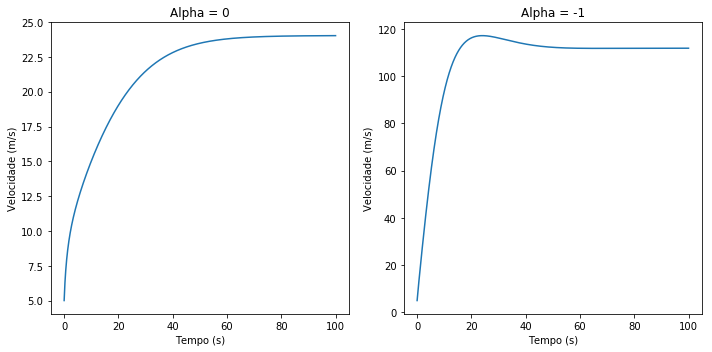

In [6]:
# Tempo de amostragem para integração numérica
sample_time = 0.01  # 0.01 segundos; intervalo de tempo entre cada amostra

# Tempo total da simulação
time_end = 100

# Instância da classe Vehicle, representando o modelo do veículo
model = Vehicle()

# Array de valores de tempo usando o intervalo de amostragem
# 0 = ponto de início, time_end = ponto final, step = espaçamento entre
t_data = np.arange(0, time_end, sample_time)

# Array de zeros para armazenar os valores de velocidade durante a simulação
v_data_alpha_0 = np.zeros_like(t_data)
v_data_alpha_minus_1 = np.zeros_like(t_data)

# Porcentagem de aceleração entre 0 e 1
throttle = 0.2

# Loop para simulação ao longo do tempo para alpha = 0
for i in range(t_data.shape[0]):
    # Armazena a velocidade atual no array v_data_alpha_0
    v_data_alpha_0[i] = model.v
    # Atualiza o modelo do veículo para o próximo passo de tempo
    model.step(throttle, 0)  # Alpha = 0

# Reinicia o modelo do veículo
model.reset()

# Loop para simulação ao longo do tempo para alpha = -1
for i in range(t_data.shape[0]):
    # Armazena a velocidade atual no array v_data_alpha_minus_1
    v_data_alpha_minus_1[i] = model.v
    # Atualiza o modelo do veículo para o próximo passo de tempo
    model.step(throttle, -1)  # Alpha = -1

# Plota os gráficos da velocidade em função do tempo
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(t_data, v_data_alpha_0)
plt.title('Alpha = 0')
plt.xlabel('Tempo (s)')
plt.ylabel('Velocidade (m/s)')

plt.subplot(1, 2, 2)
plt.plot(t_data, v_data_alpha_minus_1)
plt.title('Alpha = -1')
plt.xlabel('Tempo (s)')
plt.ylabel('Velocidade (m/s)')

plt.tight_layout()
plt.show()


We will now drive the vehicle over a slope as shown in the diagram below.

![ramp](ramp.png)

To climb the slope, a trapezoidal throttle input is provided for the next 20 seconds as shown in the figure below. 

![throttle](throttle.png)

The vehicle begins at 20% throttle and gradually increases to 50% throttle. This is maintained for 10 seconds as the vehicle climbs the steeper slope. Afterwards, the vehicle reduces the throttle to 0.

In the cell below, implement the ramp angle profile $\alpha (x)$ and throttle profile $x_\theta (t)$ and step them through the vehicle dynamics. The vehicle position $x(t)$ is saved in the array $\textit{x_data}$. This will be used to grade your solution.


In [7]:
time_end = 20  # Tempo total de simulação em segundos
t_data = np.arange(0, time_end, sample_time)  # Array de tempo de 0 a 20 segundos com intervalo de sample_time
x_data = np.zeros_like(t_data)  # Inicializa um array para armazenar a posição do veículo ao longo do tempo
v_data = np.zeros_like(t_data)  # Inicializa um array para armazenar a velocidade do veículo ao longo do tempo
w_e_data = np.zeros_like(t_data)  # Inicializa um array para armazenar a velocidade angular do motor ao longo do tempo

# Reseta os estados do modelo
model.reset()

# Função para calcular o ângulo de inclinação com base na distância percorrida
def angle_calculator(i, alpha, x):
    if x < 60:
        alpha[i] = np.arctan(3/60) # Trecho mais suave do plano inclinado
    elif x < 150:
        alpha[i] = np.arctan(9/90) # Trecho mais íngreme do plano inclinado
    else:
        alpha[i] = 0 # Trecho sem inclinação

throttle = np.zeros_like(t_data)  # Inicializa um array para armazenar as entradas do acelerador ao longo do tempo
alpha = np.zeros_like(t_data)  # Inicializa um array para armazenar os ângulos de inclinação ao longo do tempo

# Loop sobre cada passo de tempo
for i in range(t_data.shape[0]):
    # Para os primeiros 5 segundos, o acelerador aumenta linearmente de 0.2 a 0.5
    # A inclinação é calculada usando a função calcular_inclinacao
    if t_data[i] < 5:
        throttle[i] = 0.2 + ((0.5 - 0.2)/5)*t_data[i]  # Perfil de aceleração trapezoidal
        angle_calculator(i, alpha, model.x)  # Calcula o ângulo de inclinação com base na distância percorrida
    # Para os próximos 10 segundos, o acelerador é mantido constante em 0.5
    # A inclinação também é atualizada usando a função calcular_inclinacao    
    elif t_data[i] < 15:
        throttle[i] = 0.5  # Manter uma aceleração constante
        angle_calculator(i, alpha, model.x)  # Calcula o ângulo de inclinação com base na distância percorrida
    # Para os últimos segundos, o acelerador diminui linearmente de 0.5 a 0
    # A inclinação é mais uma vez calculada usando a função calcular_inclinacao
    else:
        throttle[i] = ((0 - 0.5)/(20 - 15))*(t_data[i] - 20)  # Desaceleração trapezoidal
        angle_calculator(i, alpha, model.x)  # Calcula o ângulo de inclinação com base na distância percorrida
    
    # Chama a função step e atualiza o array x_data
    model.step(throttle[i], alpha[i])
    x_data[i] = model.x
    v_data[i] = model.v
    w_e_data[i] = model.w_e

# Plot 
"""
Código Completo no Apêndice 
"""




'\nCódigo Completo no Apêndice \n'

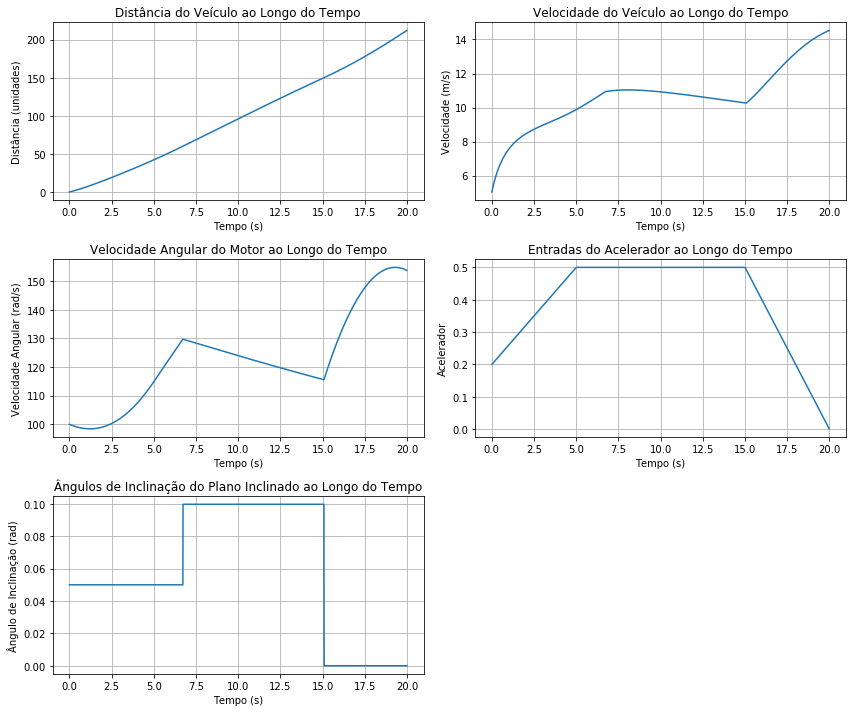

In [8]:
# ...

# Plotando todos os gráficos em um único subplot
plt.figure(figsize=(12, 10))


# Gráfico 1: Distância em função do tempo
plt.subplot(3, 2, 1)
plt.plot(t_data, x_data)
plt.title('Distância do Veículo ao Longo do Tempo')
plt.xlabel('Tempo (s)')
plt.ylabel('Distância (unidades)')
plt.grid(True)

# Gráfico 2: Velocidade em função do tempo
plt.subplot(3, 2, 2)
plt.plot(t_data, v_data)
plt.title('Velocidade do Veículo ao Longo do Tempo')
plt.xlabel('Tempo (s)')
plt.ylabel('Velocidade (m/s)')
plt.grid(True)

# Gráfico 3: Velocidade Angular do Motor em função do tempo
plt.subplot(3, 2, 3)
plt.plot(t_data, w_e_data)
plt.title('Velocidade Angular do Motor ao Longo do Tempo')
plt.xlabel('Tempo (s)')
plt.ylabel('Velocidade Angular (rad/s)')
plt.grid(True)

# Gráfico 4: Entradas do Acelerador em função do tempo
plt.subplot(3, 2, 4)
plt.plot(t_data, throttle)
plt.title('Entradas do Acelerador ao Longo do Tempo')
plt.xlabel('Tempo (s)')
plt.ylabel('Acelerador')
plt.grid(True)

# Gráfico 5: Ângulos de Inclinação em função do tempo
plt.subplot(3, 2, 5)
plt.plot(t_data, alpha)
plt.title('Ângulos de Inclinação do Plano Inclinado ao Longo do Tempo')
plt.xlabel('Tempo (s)')
plt.ylabel('Ângulo de Inclinação (rad)')
plt.grid(True)

# Exibindo o gráfico consolidado
plt.tight_layout()
plt.show()


If you have implemented the vehicle model and inputs correctly, you should see that the vehicle crosses the ramp at ~15s where the throttle input begins to decrease.

The cell below will save the time and vehicle inputs as text file named $\textit{xdata.txt}$. To locate the file, change the end of your web directory to $\textit{/notebooks/Course_1_Module_4/xdata.txt}$

Once you are there, you can download the file and submit to the Coursera grader to complete this assessment.

In [9]:
data = np.vstack([t_data, x_data]).T
np.savetxt('xdata.txt', data, delimiter=', ')

Congratulations! You have now completed the assessment! Feel free to test the vehicle model with different inputs in the cell below, and see what trajectories they form. In the next module, you will see the longitudinal model being used for speed control. See you there!

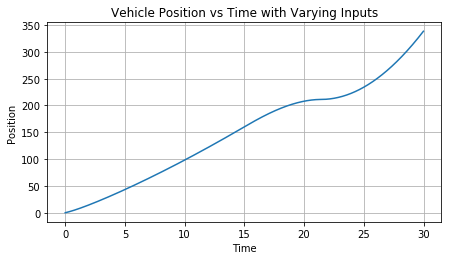

In [13]:
sample_time = 0.01
time_end = 30
model.reset()

t_data = np.arange(0, time_end, sample_time)
x_data = np.zeros_like(t_data)


# Test various inputs here
for i in range(t_data.shape[0]):
    # Varying throttle input over time
    throttle = 0.5 if i < t_data.shape[0] / 2 else 0.2

    # Varying slope angle input over time
    slope_angle = np.arctan(3 / 40) if i < t_data.shape[0] / 2 else np.arctan(6 / 40)

    # Step the model with varying inputs
    model.step(throttle, slope_angle)

    # Record the vehicle's position
    x_data[i] = model.x

# Plotting the vehicle's trajectory
# Plotando todos os gráficos em um único subplot
plt.figure(figsize=(12, 10))


# Gráfico 1:
plt.subplot(3, 2, 1)
plt.plot(t_data, x_data)
plt.xlabel('Time')
plt.ylabel('Position')
plt.title('Vehicle Position vs Time with Varying Inputs')
plt.grid(True)

plt.tight_layout()
plt.show()
